<font size=18 weight='bold'>*~ "elapsed time" visual ~*</font>


In [19]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

In [20]:
plt.show();
plt.rcParams.update({'font.size':16,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

# Definitions for this notebook:

In [21]:
f = h5py.File(f"{paths.path_data}orbitdata_40.hdf5",'r')
orbit = {}
for key, val in f.items():
    orbit[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
conversion = {}
for key, val in f.items():
    conversion[key] = np.array(val)
f.close()

In [22]:
orbit['Separations']

array([[  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [220.57520663, 241.21504159, 269.82282548, ..., 282.9575506 ,
        265.96941297,          nan],
       [  0.        ,   0.        ,   0.        , ..., 138.08676706,
        129.51058512,          nan],
       ...,
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ...,  69.59072036,
                 nan,          nan]])

In [23]:
# indices of table with [orbit['MergerFlag']==1] (thus, not universal indices)
merge_subind = [45]

# corresponding index
merge_ind = np.where(orbit['SubfindID1']==orbit['SubfindID1'][orbit['MergerFlag']==1][merge_subind])[0][0]

In [25]:
merge_ind

55

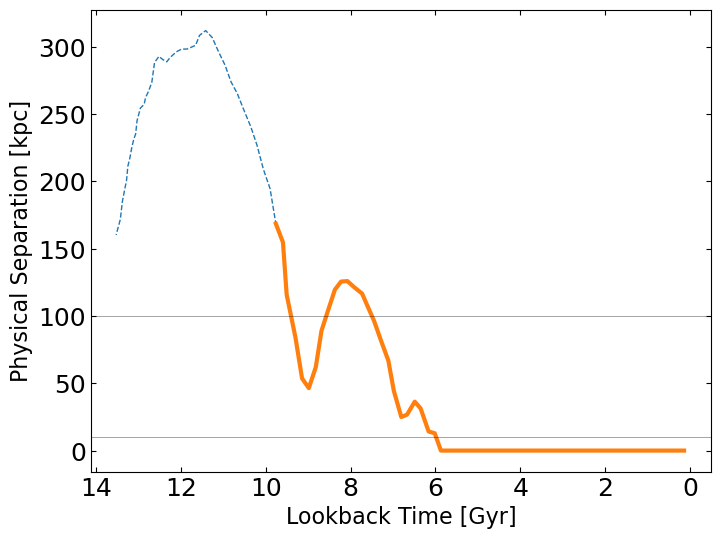

In [24]:
fig,ax = plt.subplots(figsize=(8,6))

# - non-nan - #
nonnanmask = ~np.isnan(orbit['Separations'][merge_ind])
snaps = conversion['Lookback Time'][::-1][1:][nonnanmask]
seps = orbit['Separations'][merge_ind][nonnanmask]

ax.plot(snaps, seps,linestyle='dashed', lw=1)    

# - group true - #
snaps = conversion['Lookback Time'][::-1][1:]
seps = np.where(orbit['GroupFlag'][merge_ind], orbit['Separations'][merge_ind],np.nan)

ax.plot(snaps, seps, label=merge_ind, lw=3)    

plt.ylabel("Physical Separation [kpc]")
plt.xlabel("Lookback Time [Gyr]")
ax.axhline(100,color='black',alpha=0.5,lw=0.5)
ax.axhline(10,color='black',alpha=0.5,lw=0.5)
             
plt.xlim(np.max(conversion['Lookback Time']+0.5),-0.5)

plt.show()

# Shaded vs. cumulative

In [10]:
seps_lower = np.where(seps>10,10,np.nan)
seps_upper = np.where(seps<100,seps,np.nan)

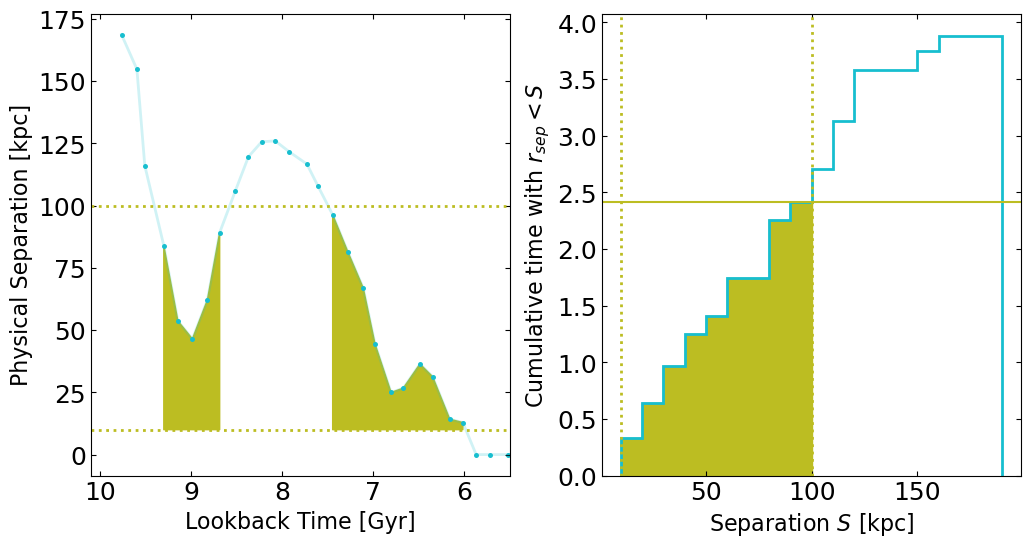

In [11]:
fig,ax = plt.subplots(1,2,figsize=(12,6),
                     gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.22,
                                    "hspace":0.0})

col='tab:cyan'
c = 'tab:olive'
a = 1
lw = 2
ls = 'dotted'  
    
# - plot orbit - #
snaps = conversion['Lookback Time'][::-1][1:]
seps = np.where(orbit['GroupFlag'][merge_ind], orbit['Separations'][merge_ind],np.nan)




ax[0].fill_between(snaps,seps_upper,seps_lower,color=c)
ax[0].plot(snaps, seps, label=merge_ind, lw=2,color=col,alpha=0.2)    
ax[0].scatter(snaps, seps, lw=2,marker='.',s=10,color=col,label='Snapshot')   


ax[0].set_ylabel("Physical Separation [kpc]")
ax[0].set_xlabel("Lookback Time [Gyr]")
ax[0].invert_xaxis()   
ax[0].set_xlim(10.1,5.5)   


# - plot cumulative separation - #
elapsed = np.diff(snaps)

bins = np.arange(10,200,10)
vals, edges = np.histogram(seps[:-1],bins=bins,weights=elapsed)




mask = edges[:-1]<=100
ax[1].fill_between(edges[edges<=100],np.cumsum(vals[mask]),0,step='post',color=c)
ax[1].stairs(np.cumsum(vals),edges=edges,lw=2,color=col)
ax[1].set_ylabel(r"Cumulative time with $r_{sep}<S$")
ax[1].set_xlabel("Separation $S$ [kpc]")

ax[1].axvline(100,color=c,alpha=a,lw=lw,linestyle=ls)
ax[1].axvline(10,color=c,alpha=a,lw=lw,linestyle=ls)
ax[0].axhline(100,color=c,alpha=a,lw=lw,linestyle=ls)
ax[0].axhline(10,color=c,alpha=a,lw=lw,linestyle=ls)

ax[1].axhline(np.cumsum(vals[edges[:-1]<100])[-1],color=c)

# plt.xlim(np.max(conversion['Lookback Time']+0.5),-0.5)
# plt.savefig('../plots/5_methods/methods.pdf')

plt.show()

# interpolation?

In [59]:
# index of example orbit to plot
merge_ind = 55

# - non-nan - #
nonnanmask = ~np.isnan(orbit['Separations'][merge_ind])
nonnantime = conversion['Lookback Time'][::-1][1:][nonnanmask]
nonnanseps = orbit['Separations'][merge_ind][nonnanmask]


# - group true - #
grouptime = conversion['Lookback Time'][::-1][1:]
groupseps = np.where(orbit['GroupFlag'][merge_ind], orbit['Separations'][merge_ind],np.nan)

# fine snapshot 
time_fine = np.linspace(10,5.5,1000)


linearseps = np.interp(time_fine, xp=grouptime, fp=groupseps) 

spline = CubicSpline(nonnantime, np.where(~np.isnan(nonnanseps),nonnanseps,0))
cubicseps = spline(time_fine)



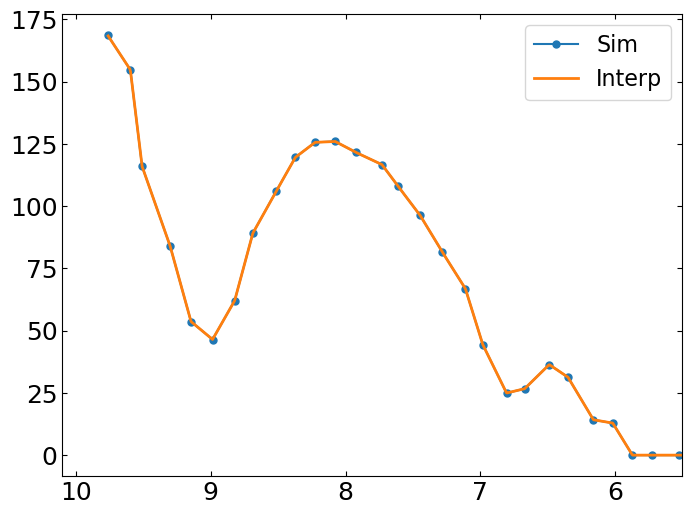

In [73]:
# plot of the data vs. fits
fig,ax = plt.subplots(figsize=(8,6))
 
ax.plot(grouptime, groupseps, label='Sim', marker='.',ms=10)    
ax.plot(time_fine, linearseps, lw=2,label='Interp')    
 
ax.set_xlim(10.1,5.5) 
ax.legend()
# plt.ylabel("Physical Separation [kpc]")
# plt.xlabel("Lookback Time [Gyr]")
# ax.axhline(100,color='black',alpha=0.5,lw=0.5)
# ax.axhline(10,color='black',alpha=0.5,lw=0.5)
             
# plt.xlim(np.max(conversion['Lookback Time']+0.5),-0.5)

plt.show()

In [89]:
group_upper = np.where(groupseps<100,groupseps,np.nan)
group_lower = np.where(groupseps>10,10,np.nan)
linear_upper = np.where(linearseps<100,linearseps,np.nan)
linear_lower = np.where(linearseps>10,10,np.nan)

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

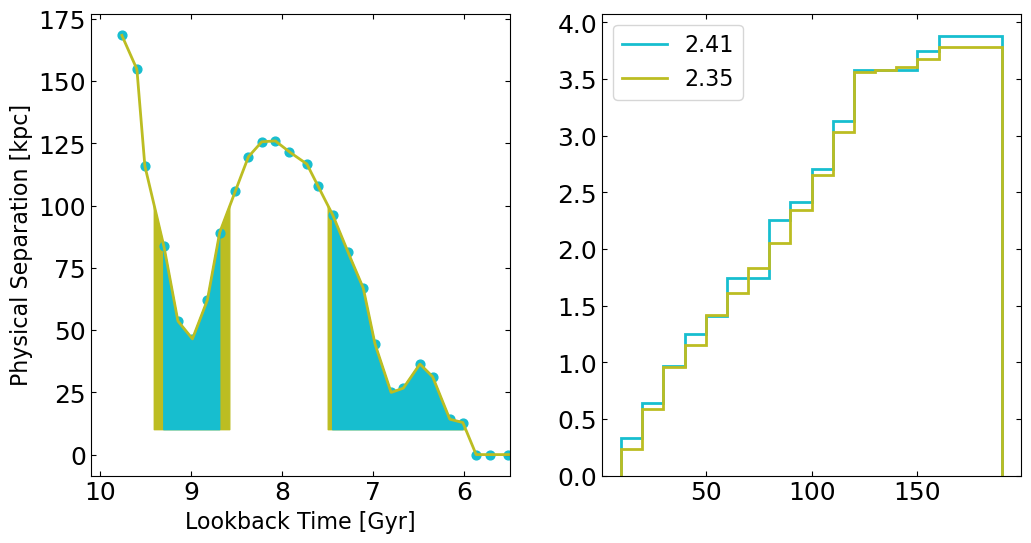

In [114]:
fig,ax = plt.subplots(1,2,figsize=(12,6),
                     gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.22,
                                    "hspace":0.0})

col='tab:cyan'
c = 'tab:olive'
a = 1
lw = 2
ls = 'dotted'  
    
# - plot orbit - #


ax[0].plot(time_fine, linearseps, lw=2,label='Interp',color=c)     
ax[0].fill_between(time_fine,linear_upper,linear_lower,color=c)

ax[0].scatter(grouptime, groupseps, label='Sim', s=40,color=col)
ax[0].fill_between(grouptime,group_upper,group_lower,color=col)


# - plot cumulative separation - #
elapsed = np.diff(grouptime)
elapsed_fine = np.abs(np.diff(time_fine))
bins = np.arange(10,200,10)

groupvals, groupedges = np.histogram(groupseps[:-1],bins=bins,weights=elapsed)
linearvals, linearedges = np.histogram(linearseps[:-1],bins=bins,weights=elapsed_fine)

groupelapsed = np.where(groupseps[:-1]<100,np.where(groupseps[:-1]>10,elapsed,0),0)
linearelapsed = np.where(linearseps[:-1]<100,np.where(linearseps[:-1]>10,elapsed_fine,0),0)

# ax[1].fill_between(edges[edges<=100],np.cumsum(vals[mask]),0,step='post',color=c)
ax[1].stairs(np.cumsum(groupvals),edges=groupedges,lw=2,color=col,label=f"{sum(groupelapsed):.2f}")
ax[1].stairs(np.cumsum(linearvals),edges=linearedges,lw=2,color=c,label=f"{sum(linearelapsed):.2f}")
# ax[1].set_ylabel(r"Cumulative time with $r_{sep}<S$")
# ax[1].set_xlabel("Separation $S$ [kpc]")



# mask = edges[:-1]<=100


# ax[1].axvline(100,color=c,alpha=a,lw=lw,linestyle=ls)
# ax[1].axvline(10,color=c,alpha=a,lw=lw,linestyle=ls)
# ax[0].axhline(100,color=c,alpha=a,lw=lw,linestyle=ls)
# ax[0].axhline(10,color=c,alpha=a,lw=lw,linestyle=ls)

# ax[1].axhline(np.cumsum(vals[edges[:-1]<100])[-1],color=c)


ax[0].set_ylabel("Physical Separation [kpc]")
ax[0].set_xlabel("Lookback Time [Gyr]")
ax[0].invert_xaxis()   
ax[0].set_xlim(10.1,5.5)   
ax[1].legend()

# plt.xlim(np.max(conversion['Lookback Time']+0.5),-0.5)
plt.savefig('../plots/5_methods/interp_comparison.pdf')

plt.show()

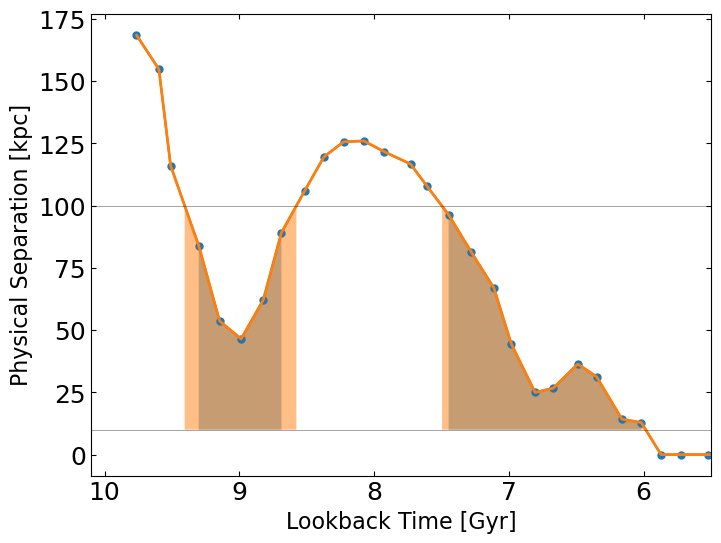

In [92]:
fig,ax = plt.subplots(figsize=(8,6))







plt.ylabel("Physical Separation [kpc]")
plt.xlabel("Lookback Time [Gyr]")
ax.axhline(100,color='black',alpha=0.5,lw=0.5)
ax.axhline(10,color='black',alpha=0.5,lw=0.5)
ax.set_xlim(10.1,5.5)   
# plt.xlim(np.max(conversion['Lookback Time']+0.5),-0.5)

# sum(diffs[~np.isnan(seps_masked[1:])])


plt.show()

In [ ]:

newdiffs =np.diff(newtimes)
newseps_masked = np.where(newseps>10,np.where(newseps<100,newseps,np.nan),np.nan)


In [ ]:
# seps_lower = np.where(seps>10,10,np.nan)
# seps_upper = np.where(seps<100,seps,np.nan)

In [36]:
newsnaps = np.linspace(10,6,1000)

newseps = np.interp(newsnaps, snaps, seps)

In [101]:
# calculate the area (and the difference between the area under the curve interp vs. non)
snaps = conversion['Lookback Time'][::-1][1:]
seps = np.where(orbit['GroupFlag'][merge_ind], orbit['Separations'][merge_ind],np.nan)
print(len(snaps),len(seps))

diffs = np.diff(conversion['Lookback Time'][::-1][:-1]) # take off sep at z = 0 to match length
seps_masked = np.where(seps>10,np.where(seps<100,seps,np.nan),np.nan)

area_old = sum(diffs[~np.isnan(seps_masked[1:])])


newsnaps = np.linspace(10,6,1000)
newtimes = np.interp(newsnaps, conversion['Lookback Time'][::-1], conversion['Lookback Time'][::-1]) 
newseps = np.interp(newsnaps, snaps, seps) 

newdiffs =np.diff(newtimes)
newseps_masked = np.where(newseps>10,np.where(newseps<100,newseps,np.nan),np.nan)


area_new = sum(newdiffs[~np.isnan(newseps_masked[1:])])

print(area_old, area_new)

# np.diff(conversion['Lookback Time'][::-1][:-1]) # take off sep at z = 0 to match length
# seps_masked = np.where(seps>10,np.where(seps<100,seps,np.nan),np.nan)

# area_old = sum(diffs[~np.isnan(seps_masked[1:])])



# newseps_lower = np.where(newseps>10,10,np.nan)
# newseps_upper = np.where(newseps<100,newseps,np.nan)

# new = np.interp(newsnaps, snaps, seps)

99 99
2.3317184781821796 -2.33033033033033


In [102]:
newtimes

array([10.        ,  9.995996  ,  9.99199199,  9.98798799,  9.98398398,
        9.97997998,  9.97597598,  9.97197197,  9.96796797,  9.96396396,
        9.95995996,  9.95595596,  9.95195195,  9.94794795,  9.94394394,
        9.93993994,  9.93593594,  9.93193193,  9.92792793,  9.92392392,
        9.91991992,  9.91591592,  9.91191191,  9.90790791,  9.9039039 ,
        9.8998999 ,  9.8958959 ,  9.89189189,  9.88788789,  9.88388388,
        9.87987988,  9.87587588,  9.87187187,  9.86786787,  9.86386386,
        9.85985986,  9.85585586,  9.85185185,  9.84784785,  9.84384384,
        9.83983984,  9.83583584,  9.83183183,  9.82782783,  9.82382382,
        9.81981982,  9.81581582,  9.81181181,  9.80780781,  9.8038038 ,
        9.7997998 ,  9.7957958 ,  9.79179179,  9.78778779,  9.78378378,
        9.77977978,  9.77577578,  9.77177177,  9.76776777,  9.76376376,
        9.75975976,  9.75575576,  9.75175175,  9.74774775,  9.74374374,
        9.73973974,  9.73573574,  9.73173173,  9.72772773,  9.72

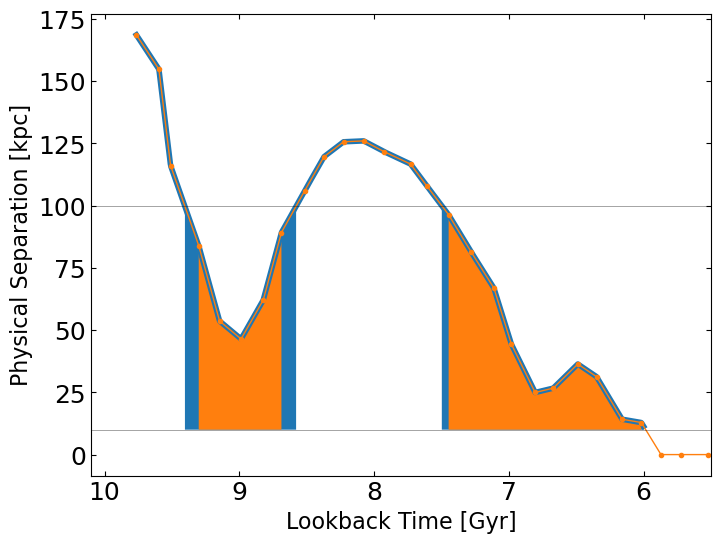

In [48]:
fig,ax = plt.subplots(figsize=(8,6))

# - group true - #
snaps = conversion['Lookback Time'][::-1][1:]
seps = np.where(orbit['GroupFlag'][merge_ind], orbit['Separations'][merge_ind],np.nan)

ax.plot(newsnaps, newseps,lw=4)   
ax.plot(snaps, seps, label=merge_ind, lw=1,marker='.')    
 

ax.fill_between(newsnaps,newseps_upper,newseps_lower)
ax.fill_between(snaps,seps_upper,seps_lower)



plt.ylabel("Physical Separation [kpc]")
plt.xlabel("Lookback Time [Gyr]")
ax.axhline(100,color='black',alpha=0.5,lw=0.5)
ax.axhline(10,color='black',alpha=0.5,lw=0.5)
ax.set_xlim(10.1,5.5)   
# plt.xlim(np.max(conversion['Lookback Time']+0.5),-0.5)

sum(diffs[~np.isnan(seps_masked[1:])])


plt.show()

In [52]:
seps_upper

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 12.86124364, 14.20518148, 31.28137754, 36.35884921,
       26.67727032, 24.93079273, 44.3252257 , 66.84747195, 81.43154449,
       96.29367735,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 89.14107434, 62.04106725,
       46.42017663, 53.63148325, 83.88719884,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [53]:
seps_upper[~np.isnan(seps_lower)]

array([12.86124364, 14.20518148, 31.28137754, 36.35884921, 26.67727032,
       24.93079273, 44.3252257 , 66.84747195, 81.43154449, 96.29367735,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, 89.14107434, 62.04106725, 46.42017663,
       53.63148325, 83.88719884,         nan,         nan,         nan])

In [57]:
snaps

array([ 0.13648833,  0.34007461,  0.47502133,  0.67625252,  0.80960087,
        1.0083923 ,  1.14008622,  1.33635449,  1.4663389 ,  1.66000232,
        1.85206448,  1.97920241,  2.16853359,  2.29382551,  2.48035043,
        2.66515681,  2.78739386,  2.96928046,  3.14938326,  3.26844946,
        3.50414693,  3.6207657 ,  3.79413961,  3.96563147,  4.07890482,
        4.24722031,  4.41360808,  4.57805312,  4.74054166,  4.90106113,
        5.0596002 ,  5.21614881,  5.37069816,  5.52324072,  5.7234985 ,
        5.87133643,  6.01715166,  6.16094216,  6.34951208,  6.48857728,
        6.6708518 ,  6.80520283,  6.98120678,  7.11086956,  7.28064697,
        7.4468931 ,  7.6096314 ,  7.7293989 ,  7.92469312,  8.07707784,
        8.22607695,  8.37172731,  8.51406791,  8.68740199,  8.82244839,
        8.98680396,  9.14629731,  9.30102237,  9.50981086,  9.59655574,
        9.76523678,  9.90101118, 10.0583425 , 10.2097357 , 10.35536972,
       10.51823531, 10.67378679, 10.82230287, 10.96405813, 11.11

In [61]:
conversion['Snapshot'][::-1]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [80]:
diffs = np.diff(conversion['Lookback Time'][::-1][:-1]) # take off sep at z = 0 to match length
print(len(diffs))

98


In [ ]:
orbit['Separations'][merge_ind]

In [89]:
seps = np.where(orbit['GroupFlag'][merge_ind], orbit['Separations'][merge_ind],np.nan)
len(seps)

99

2.3317184781821796

In [93]:
seps_masked[1:]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       12.86124364, 14.20518148, 31.28137754, 36.35884921, 26.67727032,
       24.93079273, 44.3252257 , 66.84747195, 81.43154449, 96.29367735,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, 89.14107434, 62.04106725, 46.42017663,
       53.63148325, 83.88719884,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [85]:
np.arange(99,0,-1)

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [103]:
np.diff(conversion['Lookback Time'][::-1][:-1])

array([0.13648833, 0.20358627, 0.13494672, 0.20123119, 0.13334835,
       0.19879143, 0.13169392, 0.19626828, 0.12998441, 0.19366342,
       0.19206215, 0.12713793, 0.18933118, 0.12529192, 0.18652493,
       0.18480638, 0.12223704, 0.18188661, 0.1801028 , 0.1190662 ,
       0.23569747, 0.11661877, 0.17337391, 0.17149186, 0.11327335,
       0.16831549, 0.16638777, 0.16444505, 0.16248854, 0.16051947,
       0.15853907, 0.15654861, 0.15454935, 0.15254256, 0.20025778,
       0.14783793, 0.14581523, 0.1437905 , 0.18856991, 0.1390652 ,
       0.18227452, 0.13435103, 0.17600395, 0.12966278, 0.16977741,
       0.16624613, 0.16273829, 0.11976751, 0.19529422, 0.15238472,
       0.14899911, 0.14565035, 0.1423406 , 0.17333408, 0.1350464 ,
       0.16435557, 0.15949336, 0.15472505, 0.20878849, 0.08674488,
       0.16868103, 0.1357744 , 0.15733133, 0.1513932 , 0.14563402,
       0.16286559, 0.15555149, 0.14851608, 0.14175526, 0.15407306,
       0.14598782, 0.15504758, 0.14582497, 0.09234402, 0.20121

In [104]:
conversion['Lookback Time']

array([1.36234043e+01, 1.35319346e+01, 1.34325456e+01, 1.33850239e+01,
       1.33280477e+01, 1.32858135e+01, 1.32555927e+01, 1.32069220e+01,
       1.31630779e+01, 1.31160144e+01, 1.30707110e+01, 1.30388648e+01,
       1.29590823e+01, 1.28709994e+01, 1.28373698e+01, 1.27664438e+01,
       1.26903366e+01, 1.26254714e+01, 1.25210673e+01, 1.24367836e+01,
       1.23366835e+01, 1.22623279e+01, 1.21142212e+01, 1.19908164e+01,
       1.18585489e+01, 1.16573356e+01, 1.15649916e+01, 1.14191666e+01,
       1.12641190e+01, 1.11181312e+01, 1.09640581e+01, 1.08223029e+01,
       1.06737868e+01, 1.05182353e+01, 1.03553697e+01, 1.02097357e+01,
       1.00583425e+01, 9.90101118e+00, 9.76523678e+00, 9.59655574e+00,
       9.50981086e+00, 9.30102237e+00, 9.14629731e+00, 8.98680396e+00,
       8.82244839e+00, 8.68740199e+00, 8.51406791e+00, 8.37172731e+00,
       8.22607695e+00, 8.07707784e+00, 7.92469312e+00, 7.72939890e+00,
       7.60963140e+00, 7.44689310e+00, 7.28064697e+00, 7.11086956e+00,
      